In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta,time
import os
from scipy.signal import butter, lfilter, welch, periodogram, find_peaks
from scipy.fft import fft, fftfreq, ifft, fftshift, rfft, irfft, ifftshift
import math as M
import json
import pickle
import pandas as pd
import pickle
import matplotlib.dates as mdates
import soundfile as sf
from scipy import signal
import multiprocessing

In [2]:
def axvlines(ax = None, xs = [0, 1], ymin=0, ymax=1, **kwargs):
    ax = ax or plt.gca()
    for x in xs:
        ax.axvline(x, ymin=ymin, ymax=ymax, **kwargs)
        
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
        ax = fig.add_subplot(111)
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
# the data more uniform (just average among the peaks)
def butter_bandpass(lowcut, highcut, Fs, order):
    nyq = 0.5 * Fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, Fs, order):
    b, a = butter_bandpass(lowcut, highcut, Fs, order=order)
    y = lfilter(b, a, data)
    return y  

def _nearest_pow_2(x):

    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b   

In [9]:
path = './data/'
#%cd \"./data/RC0067 Nov 2022/\"
all_files = os.listdir(path)

In [10]:
all_files = [i for i in all_files if i.endswith('.wav') and i.startswith('230124')]
#start = datetime.fromisoformat('2021-11-03T00:06:00')
#start = datetime.fromisoformat('2023-01-23T00:03:00')
#start = datetime.fromisoformat('2023-01-24T00:03:00')
start = datetime.fromisoformat('2023-01-24T00:03:00')
len(all_files)

1

In [11]:
delta = timedelta(minutes=5)
t = np.array([start + (i-1)*delta for i in range(len(all_files))])
#sunrise = time(hour=7,minute=55,second=0)
#sunset = time(17,50,0)

In [12]:
file_name = np.sort(all_files)[0]
i = sorted(all_files).index(file_name) 
#i = all_files.index("211103_0220.wav") # Example for the Paper
t_begin = t[i]
print(file_name)
print(t_begin)

230124_3156.wav
2023-01-23 23:58:00


In [20]:
a = np.array([[1,2,3], [4,5,6]])

b = np.reshape(a, (3,-1))
b = np.reshape(a, 6)
print(b)
print(np.reshape(b, (-1,2)[0]))

print(b[0:9])
print(b[2:])

# print(int(s2*fs))
print(signal_filt[0:int(s2*fs)])

[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[3 4 5 6]
[-0.00281375 -0.00951122 -0.01064999 ... -0.00290347 -0.00178903
 -0.00061976]


In [14]:
lowcut = 2000
highcut = 12000
#file_name = all_files[i]
signal_raw, fs = sf.read(path+file_name) # signal_raw: audio data(float 64 [-1, 1]), representing the wave value at certain points, fs: sample rate (how many times getting value every second)***
print(fs)
print(signal_raw.shape)
signal_raw = np.reshape(signal_raw, (-1, 2)[0]) # guess if there are two channels, making them into n*1 matrix.***
signal_raw[np.isnan(fs)] = 0
# FILTER
signal_filt = butter_bandpass_filter(signal_raw, lowcut, highcut, fs, order=3)
t_vector = np.linspace(0,signal_raw.shape[0]/fs,signal_raw.shape[0])


# Detection algorithm
signal_filt2 = butter_bandpass_filter(signal_raw, lowcut, highcut, fs, order=3)
temp = np.abs(signal_filt2).cumsum() # cumulative sum of the elements***
sta = np.zeros(len(signal_filt2))
lta = np.zeros(len(signal_filt2))
# most frequently used sampling rate
sta_ind = int(44100*2/1000) # 0.005 part short time average***
lta_ind = int(44100*100/1000) # 0.1 part long time average***
sta[0:sta_ind] = temp[0:sta_ind]
sta[sta_ind:] = (temp[sta_ind:]-temp[:-sta_ind]) / sta_ind # the average of changing in sta_ind time*
lta[0:lta_ind] = temp[0:lta_ind]
lta[lta_ind:] = (temp[lta_ind:] - temp[:-lta_ind]) / lta_ind # the average of changing in lta_ind time*
ratio = sta/lta # STA/LTA algorithm (usually used in weak-motion applications that try to record as many seismic events as possible) when the ratio become high, something happened***
ratio_norm = ratio/np.max(ratio)
ratio_norm = ratio_norm - np.mean(ratio_norm) # adjusted ratio?**

44100
(13224960,)


(80.0, 100.0, -0.5, 0.2)

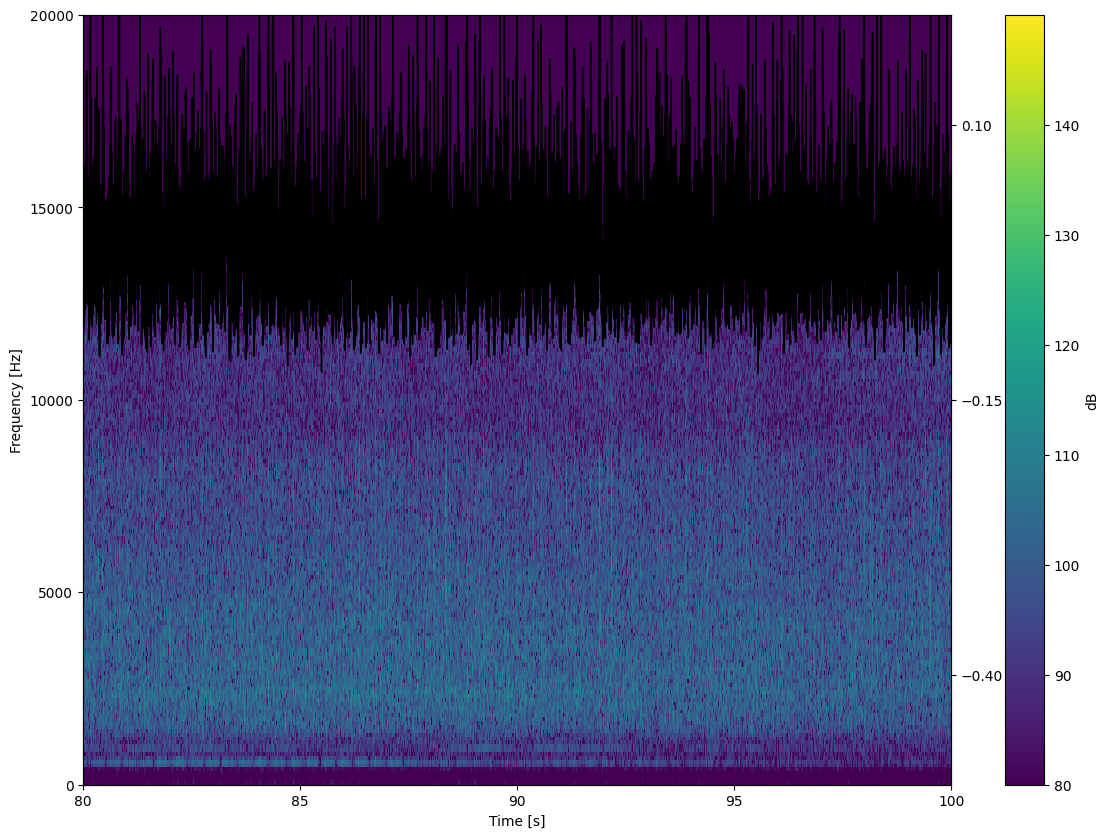

In [15]:
s1 = 0
s2 = 5*60+1 # the time we care about
nperseg = int(fs/100)
noverlap = int(0.5*nperseg)
nfft = nperseg
f_sxx, t_sxx, Sxx = signal.spectrogram(signal_filt[int(s1*fs):int(s2*fs)], fs, nfft=nfft , window = 'hann',nperseg = nperseg,noverlap = noverlap,scaling='density')

vmin = 80
vmax = 150
fig, ax = plt.subplots(figsize=(14,10))
plt.pcolormesh(t_sxx, f_sxx, 10*np.log10(Sxx)+199.4, shading='nearest',vmin = vmin,vmax = vmax)
plt.ylim(0,20000)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(ticks=np.arange(vmin,vmax,10),label = 'dB')

ax2 = ax.twinx()
ax2.plot(t_vector[0:int(s2*fs)-int(s1*fs)], ratio_norm[int(s1*fs):int(s2*fs)],'k',linewidth=1) #the black area at the middle**
plt.ylim(-0.5,0.2)
plt.yticks(np.arange(-0.4, 0.202, step=0.25))

plt.rcParams.update({'font.size': 38})
plt.axis(xmin = 80,xmax = 100)
#plt.savefig('bubble_spect_detection.tiff',bbox_inches = 'tight')

In [ ]:
s1 = 123.85
s2 = 123.875
fig, ax = plt.subplots(figsize=(16,10))
plt.plot(t_vector[int(s1*fs):int(s2*fs)],signal_filt[int(s1*fs):int(s2*fs)])

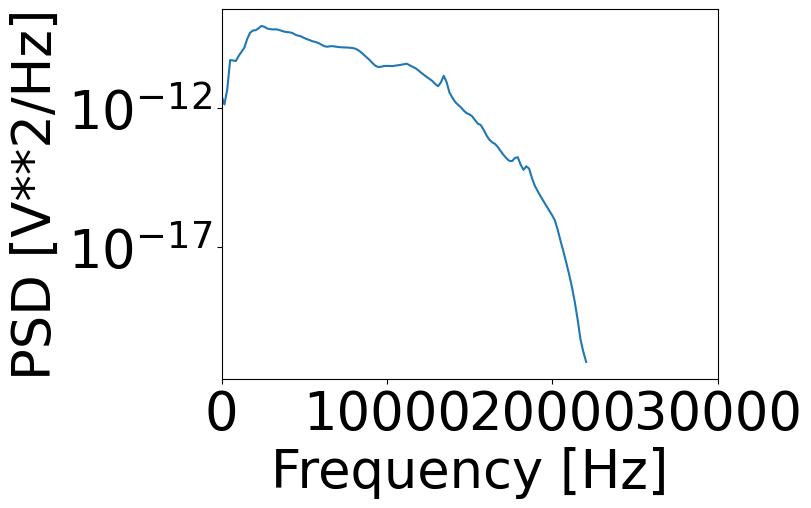

In [18]:
(f, S)= welch(signal_filt, fs) 
#Power spectral density function (PSD) shows the strength of the variations(energy) as a function of frequency. 
#In other words, it shows at which frequencies variations are strong and at which frequencies variations are weak.***

plt.semilogy(f, S)
plt.xlim([0, 30000])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()